In [2]:
# torch geometric example on node classification

In [125]:
import os
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from torch_geometric.utils import to_dense_adj
import pygsp
import seaborn as sns
import sys
sys.path.append("../")
from src.embedding import embed_MDS
from scipy.spatial.distance import pdist, squareform

In [126]:
def visualize(h, color):
    h = h.detach().cpu().numpy()
    z = embed_MDS(h, input_is_dist=False)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [127]:
# Load cora dataset, a dataset of graphs
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [128]:
# Using the first graph 
data = dataset[0]
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


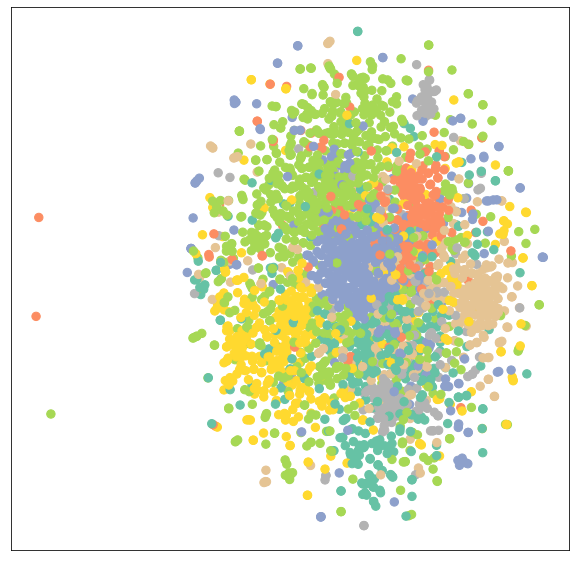

In [5]:
#plot a tsne of the data 
visualize(data.x, color=data.y)

Training with a simple GCN

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_nodes, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)

In [10]:
data.x = torch.eye(data.num_nodes)

In [11]:
# Training a GCN on node classification
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9461
Epoch: 002, Loss: 1.9331
Epoch: 003, Loss: 1.9173
Epoch: 004, Loss: 1.8938
Epoch: 005, Loss: 1.8710
Epoch: 006, Loss: 1.8393
Epoch: 007, Loss: 1.8127
Epoch: 008, Loss: 1.7797
Epoch: 009, Loss: 1.7424
Epoch: 010, Loss: 1.7281
Epoch: 011, Loss: 1.6907
Epoch: 012, Loss: 1.6474
Epoch: 013, Loss: 1.6022
Epoch: 014, Loss: 1.5723
Epoch: 015, Loss: 1.5170
Epoch: 016, Loss: 1.4889
Epoch: 017, Loss: 1.4554
Epoch: 018, Loss: 1.3993
Epoch: 019, Loss: 1.3563
Epoch: 020, Loss: 1.3005
Epoch: 021, Loss: 1.2721
Epoch: 022, Loss: 1.2318
Epoch: 023, Loss: 1.1720
Epoch: 024, Loss: 1.1411
Epoch: 025, Loss: 1.0867
Epoch: 026, Loss: 1.0519
Epoch: 027, Loss: 1.0096
Epoch: 028, Loss: 0.9691
Epoch: 029, Loss: 0.9173
Epoch: 030, Loss: 0.8924
Epoch: 031, Loss: 0.8608
Epoch: 032, Loss: 0.8305
Epoch: 033, Loss: 0.7842
Epoch: 034, Loss: 0.7746
Epoch: 035, Loss: 0.7363
Epoch: 036, Loss: 0.6740
Epoch: 037, Loss: 0.6660
Epoch: 038, Loss: 0.6328
Epoch: 039, Loss: 0.5728
Epoch: 040, Loss: 0.5626


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


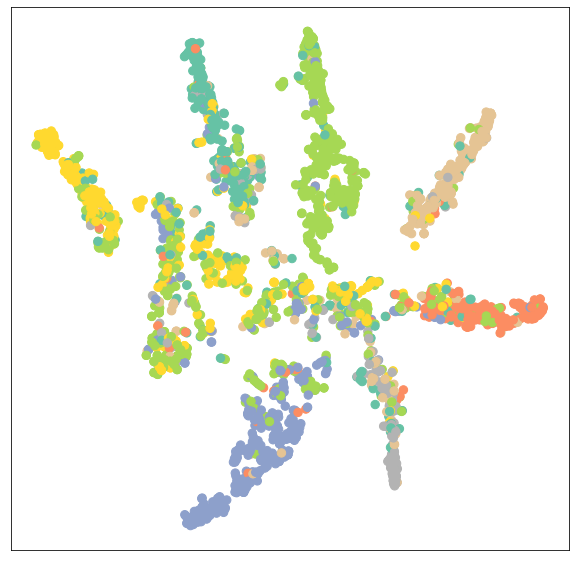

In [13]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Training by learning a Chebyshev filter

In [145]:
from torch_geometric.nn import ChebConv
class ChebGCN(torch.nn.Module):
    def __init__(self,hidden_channels,K=5):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = ChebConv(data.num_features, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes, K=K)
    
    def graph_diffusion(self,x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = (x + x.T)/2
        return x

    def forward(self, x, edge_index):
        x = self.graph_diffusion(x,edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = ChebGCN(hidden_channels=16,K=2)

In [146]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 300):
    loss = train()
    if epoch % 50 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 050, Loss: 0.4121
Epoch: 100, Loss: 0.2258
Epoch: 150, Loss: 0.1888
Epoch: 200, Loss: 0.1364
Epoch: 250, Loss: 0.1091


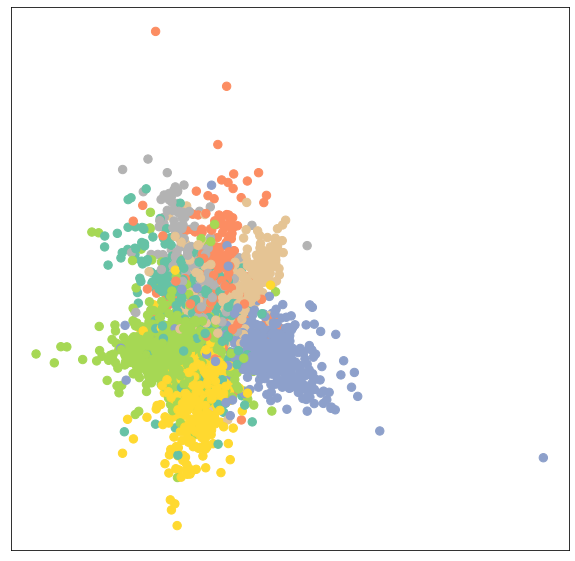

In [138]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [122]:
# Distance with cheb filter
model.eval()
out = model.graph_diffusion(data.x,data.edge_index)
kernel = out.cpu().detach().numpy()
dist = -4 * np.log(kernel + 1e-16)

In [123]:
dist.shape, dist.max(), dist.min(), torch.diag(torch.from_numpy(dist))

((2708, 16),
 147.36545,
 -0.5358527,
 tensor([147.3654, 147.3654,   4.9494, 147.3654,  27.1529,  15.0589,  18.7843,
           4.9496,   5.8362, 147.3654,   5.3576,   4.9009, 147.3654, 147.3654,
          16.1537,  15.5584]))

In [ ]:
emb = embed_MDS(dist.astype('double'))
sns.scatterplot(x=emb[:,0],y=emb[:,1], hue=data.y)

In [147]:
# Distance with proba
model.eval()
out = model(data.x,data.edge_index)
out = F.softmax(out,dim=1)
out = out.cpu().detach().numpy()

<AxesSubplot:>

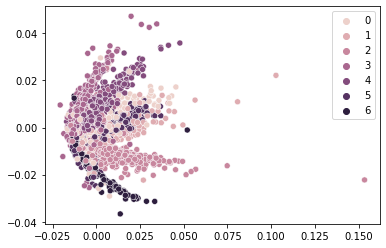

In [148]:
kernel = -np.log(out + 1e-16)
dist = squareform(pdist(kernel))
emb_train = embed_MDS(dist)
sns.scatterplot(x=emb[:,0],y=emb[:,1], hue=data.y)

In [143]:
emb_mds = embed_MDS(data.x.detach().numpy(),input_is_dist=False)

In [144]:
adj = to_dense_adj(data.edge_index).squeeze(0)
graph = pygsp.graphs.Graph(adj.cpu().detach().numpy(), lap_type="normalized")
graph.estimate_lmax()
tau = np.geomspace(0.5, 100, 10)
n = adj.shape[0]
filt = pygsp.filters.Heat(graph, tau=tau)
heat_kernel = filt.filter(np.eye(n), order=30).reshape(
            n, n, -1
        )
heat_kernel[heat_kernel < 0] = 0
multi_geo = [
            np.sqrt(-4 * tau[i] * np.log(heat_kernel[:, :, i] + 1e-16)) ** 2
            for i in range(len(tau))
        ]
weights = 1 - tau / tau.sum()
w_t = weights.sum()
weights = weights / w_t if w_t > 0 else None
dist = np.average(multi_geo, axis=0, weights=weights)
emb_heat = embed_MDS(dist)

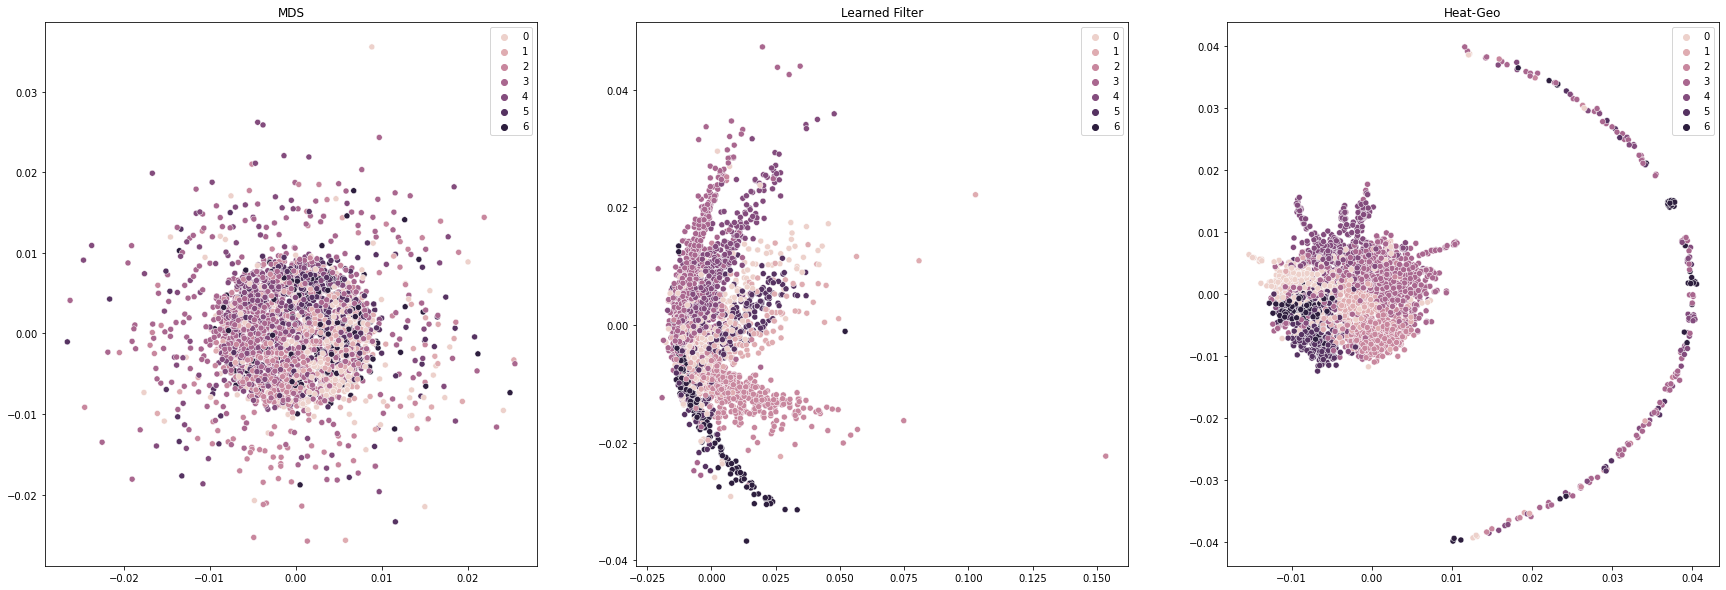

In [162]:
fig, axes = plt.subplots(1,3,figsize=(30,10))
embeddings = {"MDS": emb_mds, "Learned Filter": emb_train, "Heat-Geo":emb_heat}
for idx, (key, emb) in enumerate(embeddings.items()):
    sns.scatterplot(x=emb[:,0],y=emb[:,1], ax=axes[idx], hue=data.y).set(title=key)